# Cross-Sell Prediction
Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) et

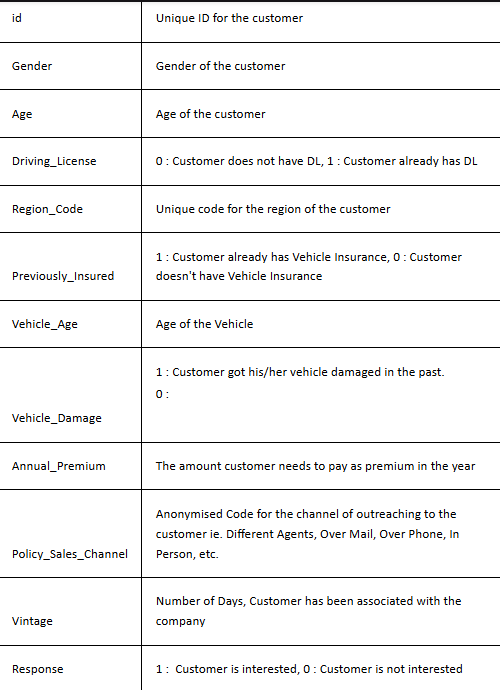c...pngc.ee.

In [2]:
# import all required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# load the data set into the notebook
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [4]:
train.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


In [5]:
test.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111


assigning new varible for target and unwanted columns 

In [7]:
tgt_col = ['Response']
ign_col = ['id']
cat_col = train.select_dtypes(include='object').columns
num_col = train.select_dtypes(include='number').drop(columns=ign_col+tgt_col).columns

In [8]:
print(tgt_col)
print(ign_col)
print(cat_col)
print(num_col)

['Response']
['id']
Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')


In [9]:
# separate the dependent and independent columns 
X = train.drop(columns = ign_col+tgt_col)
y = train[tgt_col]

# import required libraries for the building of hte pipeline


In [111]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier


# train test split

In [13]:
train_X, val_X, train_y, val_y = train_test_split(X,y, test_size=0.3, random_state=42)

In [14]:
print(train_X.shape, train_y.shape)
print (val_X.shape, val_y.shape) 

(266776, 10) (266776, 1)
(114333, 10) (114333, 1)


# model pipeline

In [16]:
numerical_transformer = ImbPipeline(
    steps = [
        ('imputer',SimpleImputer(strategy='median')),
        ('scaller',StandardScaler())
    
    ]
)

In [17]:
categorical_transformer = ImbPipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [18]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer,num_col),
        ('cat', categorical_transformer,cat_col)
    ]
)

In [19]:
# define the model 
model = LogisticRegression()

In [20]:
pipeline = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ]
)

# train the pipeline

In [22]:
pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression())])

In [23]:
def model_train_val_eval(train_X,val_X,train_y,val_y, pipeline):
    pred_train = pipeline.predict(train_X)
    pred_val = pipeline.predict(val_X)
    pred_train_proba =  pipeline.predict_proba(train_X)[:,1]
    pred_val_proba = pipeline.predict_proba(val_X)[:,1]
    print("Train Confusion. Matrix : \n",confusion_matrix(train_y, pred_train))
    print("Test Confusion. Matrix  : \n",confusion_matrix(val_y, pred_val))
    print("Train Report : \n",classification_report(train_y, pred_train))
    print("Test Report : \n",classification_report(val_y, pred_val))
    print("TRAIN ROC AUC SCORE  : \n",roc_auc_score(train_y,  pred_train))
    print("Test ROC AUC SCORE  : \n",roc_auc_score(val_y, pred_val))
    y_pred_proba=pipeline.predict_proba(val_X)[:,1]
    plt.figure()
    fpr, tpr, thrshv= roc_curve(val_y,y_pred_proba)
    plt.plot(fpr,tpr)
    plt.show()


Train Confusion. Matrix : 
 [[138923  95281]
 [   930  31642]]
Test Confusion. Matrix  : 
 [[59670 40525]
 [  401 13737]]
Train Report : 
               precision    recall  f1-score   support

           0       0.99      0.59      0.74    234204
           1       0.25      0.97      0.40     32572

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.99      0.60      0.74    100195
           1       0.25      0.97      0.40     14138

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333

TRAIN ROC AUC SCORE  : 
 0.7823093900827502
Test ROC AUC SCORE  : 
 0.7835877116296018


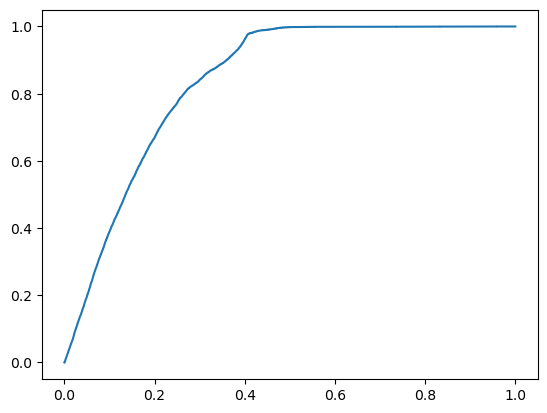

In [24]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline)

In [25]:
sub['Response']= pipeline.predict(test)

In [26]:
sub.to_csv('submission4.csv', index=False)

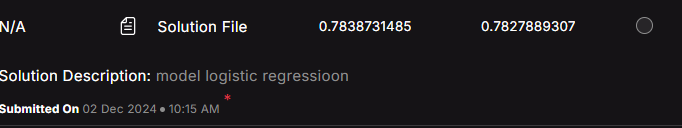

#  random forest classifier 

In [29]:
model2 = RandomForestClassifier()

In [30]:
pipeline2 = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        
        ('classifier', model2)
    ]
)

In [31]:
pipeline2.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

Train Confusion. Matrix : 
 [[234199      5]
 [    27  32545]]
Test Confusion. Matrix  : 
 [[97337  2858]
 [12447  1691]]
Train Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    234204
           1       1.00      1.00      1.00     32572

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93    100195
           1       0.37      0.12      0.18     14138

    accuracy                           0.87    114333
   macro avg       0.63      0.55      0.55    114333
weighted avg       0.82      0.87      0.83    114333

TRAIN ROC AUC SCORE  : 
 0.9995748591323811
Test ROC AUC SCORE  : 
 0.5455411780808721


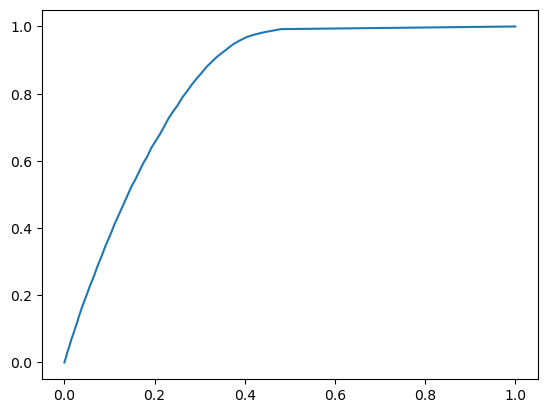

In [32]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline2)

In [33]:
sub['Response']= pipeline2.predict(test)

In [34]:
sub.to_csv('submission5.csv', index=False)

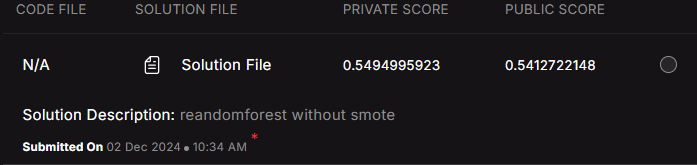

In [87]:
# random forest with smote
pipeline3 = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model2)
    ]
)

In [37]:
pipeline3.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier())])

Train Confusion. Matrix : 
 [[234189     15]
 [    12  32560]]
Test Confusion. Matrix  : 
 [[90181 10014]
 [ 8918  5220]]
Train Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    234204
           1       1.00      1.00      1.00     32572

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.91      0.90      0.91    100195
           1       0.34      0.37      0.36     14138

    accuracy                           0.83    114333
   macro avg       0.63      0.63      0.63    114333
weighted avg       0.84      0.83      0.84    114333

TRAIN ROC AUC SCORE  : 
 0.9997837693411445
Test ROC AUC SCORE  : 
 0.6346363020459234


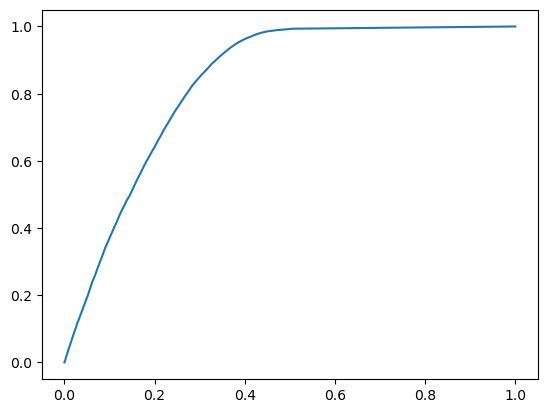

In [38]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline3)

In [39]:
sub['Response']= pipeline3.predict(test)

In [40]:
sub.to_csv('submission6.csv', index=False)

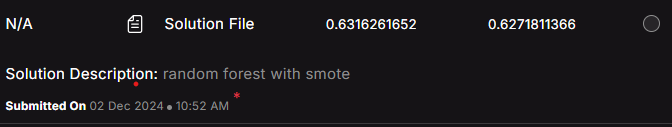

# decision tree 

In [43]:
model3 = DecisionTreeClassifier()

In [44]:
pipeline4 = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model3)
    ]
)

In [45]:
pipeline4.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', DecisionTreeClassifier())])

Train Confusion. Matrix : 
 [[234204      0]
 [    26  32546]]
Test Confusion. Matrix  : 
 [[89195 11000]
 [ 9667  4471]]
Train Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    234204
           1       1.00      1.00      1.00     32572

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90    100195
           1       0.29      0.32      0.30     14138

    accuracy                           0.82    114333
   macro avg       0.60      0.60      0.60    114333
weighted avg       0.83      0.82      0.82    114333

TRAIN ROC AUC SCORE  : 
 0.9996008841950141
Test ROC AUC SCORE  : 
 0.6032270016599616


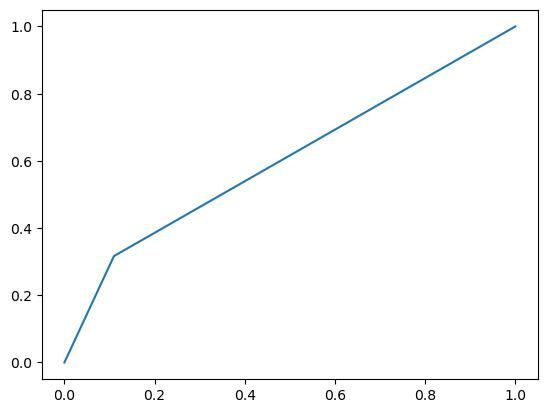

In [46]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline4)

# under sampling with decision tree classifier 


In [48]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [49]:
under_sampling=RandomUnderSampler()
train_X_under_sampled,train_y_under_sampled=under_sampling.fit_resample(train_X,train_y)
under_balanced_data=pd.concat([train_X_under_sampled,train_y_under_sampled] , axis =1)
print(under_balanced_data['Response'].value_counts())

Response
0    32572
1    32572
Name: count, dtype: int64


In [50]:
pipeline5 = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', model3)
    ]
)

In [51]:
pipeline5.fit(train_X_under_sampled,train_y_under_sampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('classifier', DecisionTreeClassifier())])

Train Confusion. Matrix : 
 [[178388  55816]
 [     6  32566]]
Test Confusion. Matrix  : 
 [[72504 27691]
 [ 4161  9977]]
Train Report : 
               precision    recall  f1-score   support

           0       1.00      0.76      0.86    234204
           1       0.37      1.00      0.54     32572

    accuracy                           0.79    266776
   macro avg       0.68      0.88      0.70    266776
weighted avg       0.92      0.79      0.82    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.95      0.72      0.82    100195
           1       0.26      0.71      0.39     14138

    accuracy                           0.72    114333
   macro avg       0.61      0.71      0.60    114333
weighted avg       0.86      0.72      0.77    114333

TRAIN ROC AUC SCORE  : 
 0.8807468231003173
Test ROC AUC SCORE  : 
 0.7146578625633897


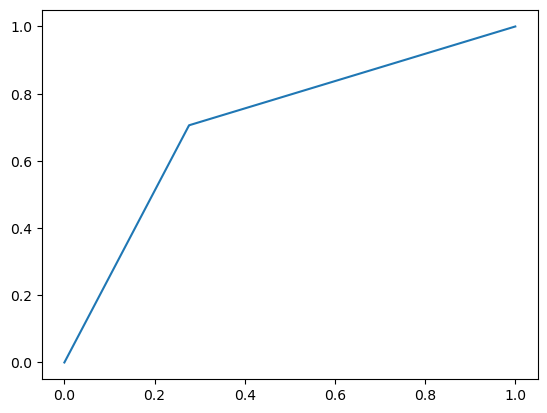

In [52]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline5)

In [53]:
pipeline6 = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', model2)
    ]
)

In [54]:
pipeline6.fit(train_X_under_sampled,train_y_under_sampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

Train Confusion. Matrix : 
 [[170791  63413]
 [     2  32570]]
Test Confusion. Matrix  : 
 [[69072 31123]
 [ 1778 12360]]
Train Report : 
               precision    recall  f1-score   support

           0       1.00      0.73      0.84    234204
           1       0.34      1.00      0.51     32572

    accuracy                           0.76    266776
   macro avg       0.67      0.86      0.68    266776
weighted avg       0.92      0.76      0.80    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.97      0.69      0.81    100195
           1       0.28      0.87      0.43     14138

    accuracy                           0.71    114333
   macro avg       0.63      0.78      0.62    114333
weighted avg       0.89      0.71      0.76    114333

TRAIN ROC AUC SCORE  : 
 0.8645894589864488
Test ROC AUC SCORE  : 
 0.7818076776032952


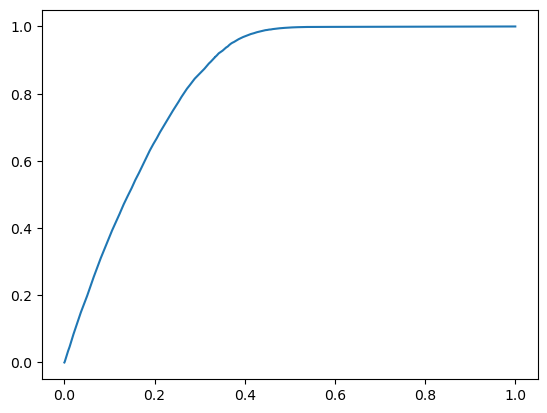

In [55]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline6)

In [56]:
sub['Response']= pipeline6.predict(test)

In [57]:
sub.to_csv('submission7.csv', index=False)

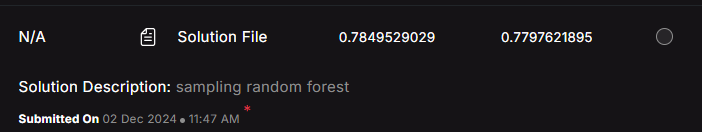

In [ ]:
!pip install catboost

In [ ]:
!pip install xgboost

In [117]:
from xgboost import XGBClassifier

# gradient boosting

In [120]:
model4 = GradientBoostingClassifier()

In [135]:
pipeline7 = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', model4)
    ]
)

In [137]:
pipeline7.fit(train_X_under_sampled,train_y_under_sampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('classifier', GradientBoostingClassifier())])

Train Confusion. Matrix : 
 [[155560  78644]
 [  2225  30347]]
Test Confusion. Matrix  : 
 [[66831 33364]
 [  950 13188]]
Train Report : 
               precision    recall  f1-score   support

           0       0.99      0.66      0.79    234204
           1       0.28      0.93      0.43     32572

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.99      0.67      0.80    100195
           1       0.28      0.93      0.43     14138

    accuracy                           0.70    114333
   macro avg       0.63      0.80      0.62    114333
weighted avg       0.90      0.70      0.75    114333

TRAIN ROC AUC SCORE  : 
 0.797948533604205
Test ROC AUC SCORE  : 
 0.7999072688156241


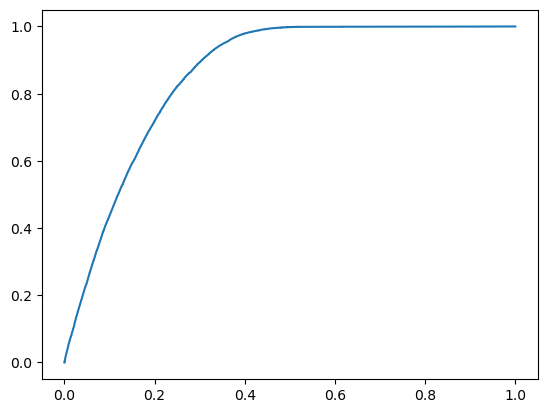

In [138]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline7)

In [141]:
sub['Response']= pipeline7.predict(test)

In [143]:
sub.to_csv('submission9.csv', index=False)

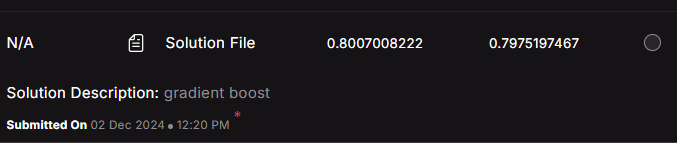

In [133]:
model5 = AdaBoostClassifier()

In [148]:
pipeline8 = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', model5)
    ]
)

In [150]:
pipeline8.fit(train_X_under_sampled,train_y_under_sampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('classifier', AdaBoostClassifier())])

Train Confusion. Matrix : 
 [[153202  81002]
 [  2044  30528]]
Test Confusion. Matrix  : 
 [[65822 34373]
 [  884 13254]]
Train Report : 
               precision    recall  f1-score   support

           0       0.99      0.65      0.79    234204
           1       0.27      0.94      0.42     32572

    accuracy                           0.69    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.69      0.74    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.99      0.66      0.79    100195
           1       0.28      0.94      0.43     14138

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.74    114333

TRAIN ROC AUC SCORE  : 
 0.7956929207716639
Test ROC AUC SCORE  : 
 0.7972062223747862


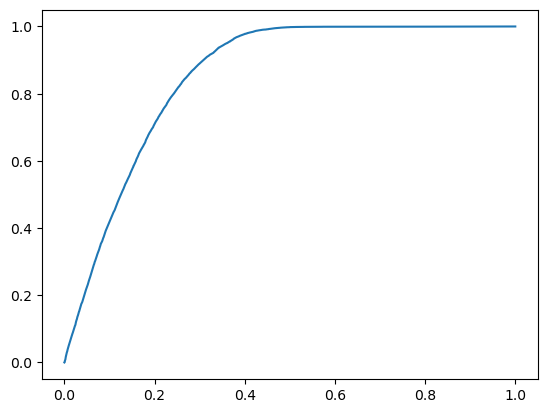

In [152]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline8)

In [154]:
sub['Response']= pipeline8.predict(test)

In [156]:
sub.to_csv('submission10.csv', index=False)

In [158]:
model6 = XGBClassifier()

In [160]:
pipeline9 = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', model6)
    ]
)

In [162]:
pipeline9.fit(train_X_under_sampled,train_y_under_sampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strat...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Train Confusion. Matrix : 
 [[159415  74789]
 [  1817  30755]]
Test Confusion. Matrix  : 
 [[67998 32197]
 [ 1185 12953]]
Train Report : 
               precision    recall  f1-score   support

           0       0.99      0.68      0.81    234204
           1       0.29      0.94      0.45     32572

    accuracy                           0.71    266776
   macro avg       0.64      0.81      0.63    266776
weighted avg       0.90      0.71      0.76    266776

Test Report : 
               precision    recall  f1-score   support

           0       0.98      0.68      0.80    100195
           1       0.29      0.92      0.44     14138

    accuracy                           0.71    114333
   macro avg       0.63      0.80      0.62    114333
weighted avg       0.90      0.71      0.76    114333

TRAIN ROC AUC SCORE  : 
 0.8124415862322709
Test ROC AUC SCORE  : 
 0.7974199776414207


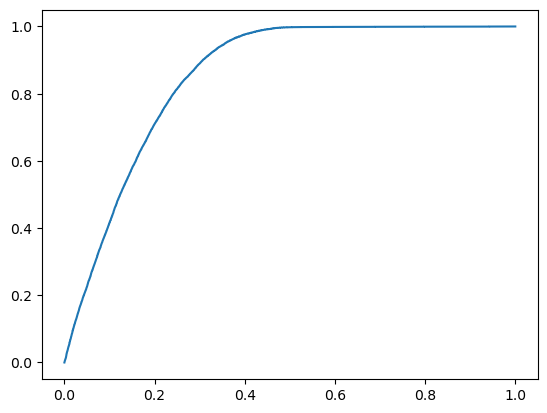

In [164]:
model_train_val_eval(train_X, val_X, train_y, val_y,pipeline9)

In [166]:
sub['Response']= pipeline9.predict(test)

In [168]:
sub.to_csv('submission11.csv', index=False)

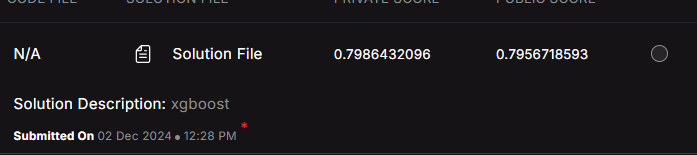

In [171]:
import joblib

In [173]:
joblib.dump(pipeline7,'cross-sell-prediction.pkl')

['cross-sell-prediction.pkl']